In **this notebook**, we'll implement a pre-trained **Inception-v3 model** to test on our dataset in place of ResNet-50. We'll also fine tune it and compare the results.

##Loading the dataset

The images and datasets are provided on GitHub here: https://github.com/AlexOlsen/DeepWeeds/tree/master . And the labels are provided here: https://github.com/AlexOlsen/DeepWeeds/tree/master/labels .

On the other hand, they can also be downloaded from TesnsorFlow dataset hub: https://www.tensorflow.org/datasets/catalog/deep_weeds .

As we've run most of our models on Kaggle, so we've downloaded the datasets from GitHub and loaded all on the kaggle account.

In [ ]:
pip install torchvision

In [ ]:
import tensorflow_datasets as tfds
import logging
from zipfile import ZipFile
import os
import sys
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#from utils.events import download_google_drive_file

In [ ]:
import os
os.listdir('/kaggle/input/deepweeds-image-classification')


['train_subset1.csv',
 'test_subset1.csv',
 'val_subset0.csv',
 'test_subset0.csv',
 'train_subset0.csv',
 'images',
 'val_subset1.csv',
 'labels.csv']

In [ ]:
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
from torchvision import transforms
import torchvision
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from PIL import ImageFile

##Applying Image Transformations


* We'll, now, apply **image transformations** to prepare the data for training and testing in our deep learning model. These transformations help to improve the model’s performance and generalization

* Additionally, in both phases, we **normalize** the images using the mean and standard deviation values derived from the ImageNet dataset. This normalization step adjusts the pixel values to a common scale, which can expedite the training process and enhance model performance.

In [ ]:
# Custom dataset class

class ImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name)
        label = int(self.data_frame.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label


# Load the CSV file
train_csv_file = '/kaggle/input/deepweeds-image-classification/train_subset0.csv'  # Replace with your actual path
test_csv_file = '/kaggle/input/deepweeds-image-classification/test_subset0.csv'  # Replace with your actual path
val_csv_file = '/kaggle/input/deepweeds-image-classification/val_subset0.csv'  # Replace with your actual path
img_dir = '/kaggle/input/deepweeds-image-classification/images'  # Replace with your images directory


# Image transformations (resize, normalization, etc.)
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resizing to 299x299, you can adjust this
    transforms.ToTensor(),  #Converts the image into a PyTorch tensor and scales pixel values to [0, 1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])     #Normalizes the image with a mean and standard deviation of [0.5, 0.5, 0.5] for the three RGB channels.
  ])


# Create the train and test datasets
train_dataset = ImageDataset(csv_file=train_csv_file, img_dir=img_dir, transform=transform)
test_dataset = ImageDataset(csv_file=test_csv_file, img_dir=img_dir, transform=transform)
val_dataset = ImageDataset(csv_file=val_csv_file, img_dir=img_dir, transform=transform)


# Create DataLoaders for batching
def create_dataloader(loader_type):
  if loader_type=='train':
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    print(f"len train_loader {len(train_loader)}")
    return train_loader
  elif loader_type=='val':
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    return val_loader
  else:
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    return test_loader


In [ ]:
# Checking & printing the size of datasets

num_train_samples = len(train_dataset)
num_val_samples = len(val_dataset)
num_test_samples = len(test_dataset)
print(f"Number of training samples: {num_train_samples}")
print(f"Number of validation samples: {num_val_samples}")
print(f"Number of testing samples: {num_test_samples}")

Number of training samples: 10501
Number of validation samples: 3501
Number of testing samples: 3507


#The Model

In [ ]:
# Load the pre-trained Inception v3 model:
model = models.inception_v3(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 9)  # Adjust for CIFAR-10 (8 classes)

# Loss function and optimizer:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training History and Device Setup:
history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }

best_val_accuracy = 0.0
best_model_path = "best_model_pretrained.pth"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# Dataloaders:
train_loader = create_dataloader(loader_type='train')
val_loader = create_dataloader(loader_type='val')

# Training Loop:
for epoch in range(100):              #You can adjust the number of epochs
          #training phase-
          model.train()
          running_loss = 0.0
          train_correct = 0
          train_total = 0
          #batch processing
          for i, (inputs, targets) in enumerate(train_loader):
              ImageFile.LOAD_TRUNCATED_IMAGES = True
              inputs, targets = inputs.to(device), targets.to(device)

              optimizer.zero_grad()
              outputs = model(inputs)
              _, predicted = outputs[0].max(1)    # Use output[0] to avoid error
              loss = criterion(outputs[0], targets)     # Only use the main output for loss calculation
              loss.backward()
              optimizer.step()
              #training metrics-
              running_loss += loss.item()
              train_total += targets.size(0)
              train_correct += predicted.eq(targets).sum().item()

              if i % 100 == 0:
                  print(f'Epoch [{epoch+1}/100], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

          #training metrics-
          train_loss = running_loss / len(train_loader)
          train_accuracy = train_correct / train_total
          history['train_loss'].append(train_loss)
          history['train_accuracy'].append(train_accuracy)

          # Validation Loop:
          model.eval()
          val_loss = 0.0
          val_correct = 0
          val_total = 0
          with torch.no_grad():
            for inputs, targets in val_loader:
              inputs, targets = inputs.to(device), targets.to(device)
              outputs = model(inputs)
              _, predicted = outputs.max(1)
              loss = criterion(outputs, predicted)

              val_loss += loss.item()
              val_total += targets.size(0)
              val_correct += predicted.eq(targets).sum().item()

          # Calculate accuracy
          val_loss /= len(val_loader)
          val_accuracy = val_correct / val_total
          history['val_loss'].append(val_loss)
          history['val_accuracy'].append(val_accuracy)

          print(f'Epoch [{epoch+1}/100], Validation Accuracy: {val_accuracy:.4f}, Train Accuracy: {train_accuracy:.4f}')

          # Save Best Model / Model Checkpointing:
          if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with Validation Accuracy: {val_accuracy:.4f}")


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 197MB/s] 


len train_loader 329
Epoch [1/100], Step [1/329], Loss: 2.2564
Epoch [1/100], Step [101/329], Loss: 0.5581
Epoch [1/100], Step [201/329], Loss: 0.6390
Epoch [1/100], Step [301/329], Loss: 0.3830
Epoch [1/100], Validation Accuracy: 0.8852, Train Accuracy: 0.7723
New best model saved with Validation Accuracy: 0.8852
Epoch [2/100], Step [1/329], Loss: 0.3376
Epoch [2/100], Step [101/329], Loss: 0.3066
Epoch [2/100], Step [201/329], Loss: 0.0924
Epoch [2/100], Step [301/329], Loss: 0.1509
Epoch [2/100], Validation Accuracy: 0.9149, Train Accuracy: 0.9316
New best model saved with Validation Accuracy: 0.9149
Epoch [3/100], Step [1/329], Loss: 0.0292
Epoch [3/100], Step [101/329], Loss: 0.1233
Epoch [3/100], Step [201/329], Loss: 0.1260
Epoch [3/100], Step [301/329], Loss: 0.0876
Epoch [3/100], Validation Accuracy: 0.9249, Train Accuracy: 0.9675
New best model saved with Validation Accuracy: 0.9249
Epoch [4/100], Step [1/329], Loss: 0.0416
Epoch [4/100], Step [101/329], Loss: 0.0477
Epoch [4

In [ ]:
history

{'train_loss': [0.6918087820876333,
  0.21669127861190712,
  0.10027522095521532,
  0.06260728125961491,
  0.06868385420942334,
  0.049784867377105343,
  0.04427980197102432,
  0.03573475209755489,
  0.041888097733171446,
  0.036680444205812485,
  0.03258412116080506,
  0.03611601461333684,
  0.03588492205645323,
  0.02264035676427661,
  0.026330577203488022,
  0.03720202389573763,
  0.018939810909495737,
  0.013518538709328648,
  0.022681278164973017,
  0.014728811569379198,
  0.030933999605611318,
  0.01968521191275892,
  0.014550803309248295,
  0.03183732470605412,
  0.039337698345802904,
  0.03491828025318328,
  0.031498387312190325,
  0.009983007452612755,
  0.01258926903402373,
  0.008688343492284202,
  0.011359770253579675,
  0.02659394453498351,
  0.054739153907023226,
  0.016096984712952976,
  0.01695963987510221,
  0.005439444634889848,
  0.005581372338447099,
  0.024758421570141544,
  0.019189006349604045,
  0.01356323266726629,
  0.012808791970054613,
  0.034348083842812197

Let's plot the above matrices for visualization.

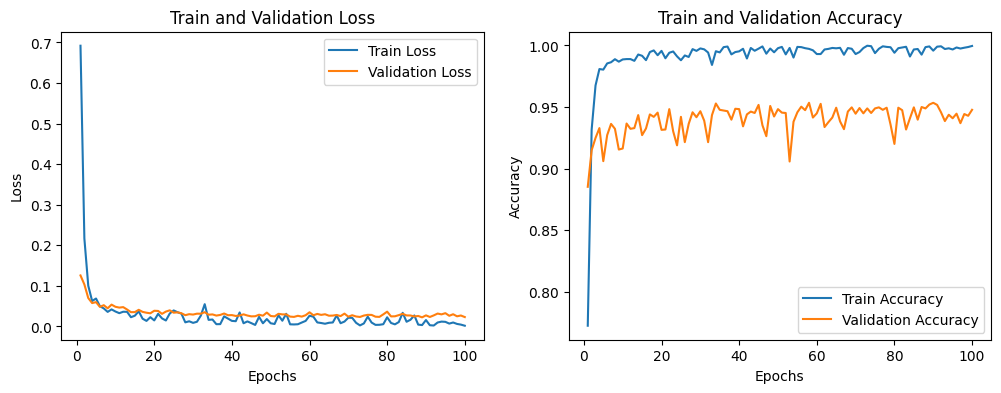

In [ ]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.legend()

    plt.show()

plot_history(history)

So from above we can see that our pre-trained model performs really good:
* The training accuracy approaches 1.0 (100%) at the end of the training.
* Wherelese, the validation accuracy fluctuates but ends around 0.95 (95%).

# Testing the model:-

**Let's first test our model on a single image picked randomly.**

/tmp/ipykernel_30/3020517046.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Test Accuracy: 0.9487


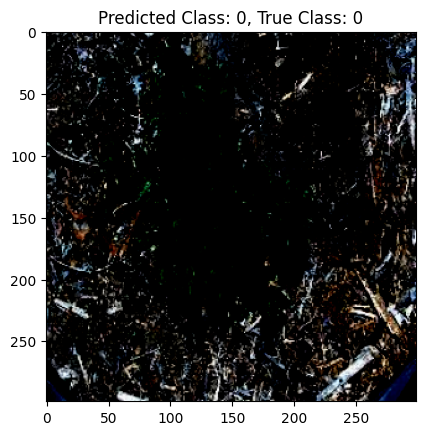

Predicted Class: 0
True Class: 0


In [ ]:
# Load the best model
model.load_state_dict(torch.load(best_model_path))
model.eval()  # Set model to evaluation mode

# Create test loader (assumes a function `create_dataloader` exists)
test_loader = create_dataloader(loader_type='test')

# Evaluate model on the test set
test_correct = 0
test_total = 0

with torch.no_grad():  # Disable gradient calculation for testing
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)  # Get predictions
        test_total += targets.size(0)
        test_correct += predicted.eq(targets).sum().item()

test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.4f}')

# Choose a random image from the test loader and plot it
dataiter = iter(test_loader)
images, labels = next(dataiter)  # Use next() to get a batch

# Randomly select an image from the batch
random_index = np.random.randint(0, len(images))
image = images[random_index]
label = labels[random_index]

# Move the image to the appropriate device and make prediction
image_tensor = image.unsqueeze(0).to(device)
output = model(image_tensor)
_, predicted_class = output.max(1)

# Convert image to CPU and detach for plotting
image = image.cpu().numpy().transpose((1, 2, 0))  # Convert to numpy array for plotting
image = np.clip(image, 0, 1)  # Normalize pixel values for display

# Plot the image
plt.imshow(image)
plt.title(f'Predicted Class: {predicted_class.item()}, True Class: {label.item()}')
plt.show()

# Print the predicted class
print(f"Predicted Class: {predicted_class.item()}")
print(f"True Class: {label.item()}")

**Now, let's test on a batch of images picked randomly.**

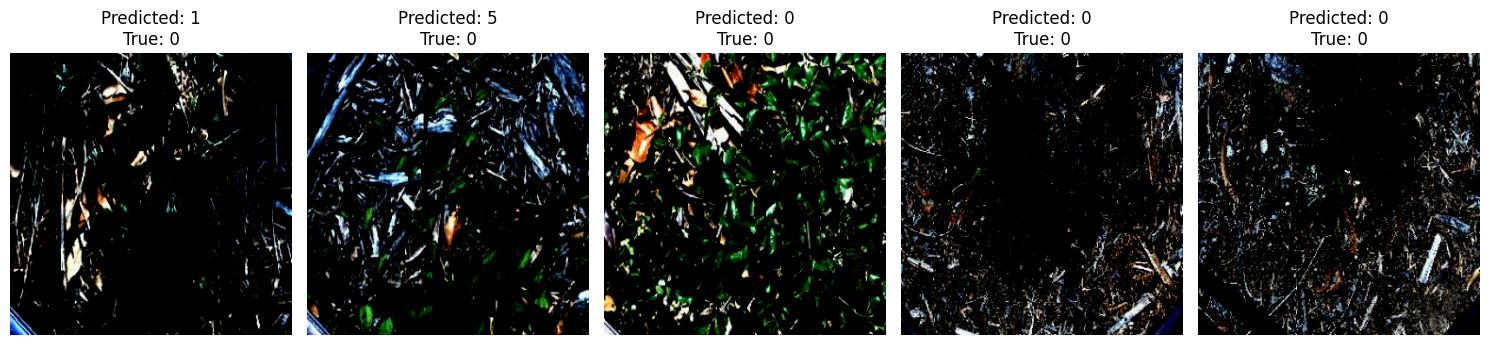

Image 1:
    Predicted Class: 1
    True Class: 0
Image 2:
    Predicted Class: 5
    True Class: 0
Image 3:
    Predicted Class: 0
    True Class: 0
Image 4:
    Predicted Class: 0
    True Class: 0
Image 5:
    Predicted Class: 0
    True Class: 0


In [ ]:
# Evaluate the model on a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)  # Get a batch of images and their labels

# Move images and labels to the appropriate device
images, labels = images.to(device), labels.to(device)

# Make predictions on the batch
outputs = model(images)
_, predicted_classes = outputs.max(1)

# Convert images back to CPU for visualization
images = images.cpu().numpy().transpose((0, 2, 3, 1))  # Convert to numpy array (N, H, W, C)
images = np.clip(images, 0, 1)  # Normalize pixel values for display

# Plot multiple images with their predicted and true labels
num_images_to_plot = 5  # Number of images to display
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 5))

for idx in range(num_images_to_plot):
    axes[idx].imshow(images[idx])
    axes[idx].set_title(
        f"Predicted: {predicted_classes[idx].item()}\nTrue: {labels[idx].item()}"
    )
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Print predictions and true labels for the displayed images
for idx in range(num_images_to_plot):
    print(f"Image {idx + 1}:")
    print(f"    Predicted Class: {predicted_classes[idx].item()}")
    print(f"    True Class: {labels[idx].item()}")
